#<center>Assignemnt-2</center>
## GMLFA-Autumn,2024
---

### This is the supporting Notbook for the given assignment. You will be provided with the instructions and code skeleton of the questions.

1. Please implement the codes on your own cosidering plagarism policy.
2. Write code for corresponding questions in their designated places.
3. Each group have to submit only one notebook (.ipynb) or python (.py) file.

## Group Informtion: To be filled by the candidates.

### Group Number: __8__
### Members Roll Numbers: SandipanMajhi(24AI60R21), Aayush Sugandh (24AI60R04)


# Dataset

QM9 Dataset:

The QM9 dataset is a widely used benchmark dataset in the field of graph neural networks (GNNs) and molecular property prediction. It contains about 134,000 small organic molecules with up to 9 heavy atoms (C, O, N, F). Each molecule is represented as a graph, where atoms are nodes and bonds are edges.

Key features of QM9:
- Number of graphs: ~134,000
- Node features: Atom properties (e.g., atomic number, charge)
- Edge features: Bond properties (e.g., bond type)
- Graph labels: Various molecular properties (e.g., energy, dipole moment)
	Available target properties:
0: mu, 1: alpha, 2: homo, 3: lumo, 4: gap, 5: r2, 6: zpve, 7: U0, 8: U, 9: H, 10: G, 11:Cv, 12: omega1

Link: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM9.html

The dataset is used for regression tasks, predicting molecular properties from graph structures.

**Use Case:**
We are going to use 1000 graphs for training, 100 graphs for validation and 100 graphs for test.
We will use ‘0: mu (dipole moment)’, first property, as a label for the regression task.
You will get the Data-Loaded in the code notebook.
This is the Regression task so you have to take one label for every graph.


In [84]:
#### Install Packages
!pip install torch_geometric networkx karateclub gdown

#### Restart session after running this cell

In [2]:
#### Import packages
import torch
import torch_geometric
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import random_split
from torch_geometric.datasets import QM9
from torch_geometric.data import DataLoader
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import to_networkx
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree


In [8]:
# Load the QM9 dataset
dataset = QM9(root='data/QM9')

# Access a single graph in the dataset
data = dataset[0]

# Print general information about the dataset
print(f"Number of graphs in the dataset: {len(dataset)}")
print(f"Number of features per node: {data.x.shape[1]}")
print(f"Number of edge features: {data.edge_attr.shape[1]}")
print(f"Number of nodes in the first graph: {data.num_nodes}")
print(f"Number of edges in the first graph: {data.num_edges}")
print(f"Number of edge features in the first graph: {data.edge_attr.size()}")

# Investigate the node features
print("\nNode features:")
print(data.x)

# Investigate the edge features
print("\nEdge features:")
print(data.edge_attr)

# Investigate the adjacency list (edges)
print("\nEdges (connectivity):")
print(data.edge_index)

# Investigate the target properties (e.g., energy, dipole moment)
print("\nTarget properties:")
print(data.y)

Number of graphs in the dataset: 130831
Number of features per node: 11
Number of edge features: 4
Number of nodes in the first graph: 5
Number of edges in the first graph: 8
Number of edge features in the first graph: torch.Size([8, 4])

Node features:
tensor([[0., 1., 0., 0., 0., 6., 0., 0., 0., 0., 4.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

Edge features:
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])

Edges (connectivity):
tensor([[0, 0, 0, 0, 1, 2, 3, 4],
        [1, 2, 3, 4, 0, 0, 0, 0]])

Target properties:
tensor([[    0.0000,    13.2100,   -10.5499,     3.1865,    13.7363,    35.3641,
             1.2177, -1101.4878, -1101.4098, -1101.3840, 

# Preparing dataset for for the further process:

In [9]:
# Creating a DataLoader

def create_dataloader(dataset, batch_size=50, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

trainloader = create_dataloader(dataset[:2500])  # Using a subset for demonstration
valloader = create_dataloader(dataset[1000:1100],shuffle=False)
testloader = create_dataloader(dataset[1100:1200],shuffle=False)

print(f"Number of batches in train_loader: {len(trainloader)}")
print(f"Number of batches in val_loader: {len(valloader)}")
print(f"Number of batches in test_loader: {len(testloader)}")

Number of batches in train_loader: 50
Number of batches in val_loader: 2
Number of batches in test_loader: 2


# Part-1:

References:
1. https://karateclub.readthedocs.io/en/latest/_modules/karateclub/node_embedding/neighbourhood/node2vec.html

2. https://karateclub.readthedocs.io/en/latest/_modules/karateclub/node_embedding/neighbourhood/deepwalk.html





In [10]:
#### Important Note - Extracting Node2Vec and DeepWalk embeddings takes time ~20 minutes 
#### So we have already extracted and them and saved it beforehand. Download them here
!gdown --id 1sz3CeFWfOERoF5UW7Q06LUr_uoKoGtqG
!gdown --id 1u8SD2AJB754yyqhOIOwh_HPA1nPVVWda

/home/sandipanmajhi/Desktop/Courses/GML_FA/Assignment_2_GMLFA/gat/lib/python3.12/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1sz3CeFWfOERoF5UW7Q06LUr_uoKoGtqG
To: /home/sandipanmajhi/Desktop/Courses/GML_FA/Assignment_2_GMLFA/graph_embeds.pkl
100%|██████████████████████████████████████| 1.30M/1.30M [00:00<00:00, 1.87MB/s]
/home/sandipanmajhi/Desktop/Courses/GML_FA/Assignment_2_GMLFA/gat/lib/python3.12/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1u8SD2AJB754yyqhOIOwh_HPA1nPVVWda
To: /home/sandipanmajhi/Desktop/Courses/GML_FA/Assignment_2_GMLFA/graph_targets.pkl
100%|███████████████████████

In [11]:
from tqdm import tqdm
from karateclub import Node2Vec, DeepWalk
import os
import pickle as pkl

##### Defining the Node2Vec and DeepWalk Model
node2vec_model = Node2Vec(dimensions = 64, walk_length = 10, walk_number = 50, p = 1, q = 0.5)
deepwalk_model = DeepWalk(dimensions = 64, walk_length = 10, walk_number = 50)

##### Check if graph emebeds have already been downloaded or not if not downloaded then extract ####
if not os.path.exists("graph_embeds.pkl") and not os.path.exists("graph_targets.pkl"):
  print("Preparing to extract Graph embeddings")
 
  ##### Preparing dicts for saving embeddings
  graph_embeds = {
    "Deepwalk" : {
      "train" : [],
      "val" : [],
      "test" : []
    },
    "Node2Vec" : {
      "train" : [],
      "val" : [],
      "test" : []
    }
  }
  targets = {
      "train" : [],
      "val" : [],
      "test" : []
  }

  #### Train = 1000 Graphs
  #### Validation : 100 Graphs
  #### Test : 100 Graphs

  train_data = dataset[:1000]
  val_data = dataset[1000:1100]
  test_data = dataset[1100:1200]

  #### Here the main idea is that we would extract the embeddings from the graphs and save them
  #### so that we do not have re-calculate again and again. It takes time to calculate embeddings 
  #### and save them for future use. 

  def create_embeddings(data, input_store, targets, split = "train"):
    for i in tqdm(range(len(data)), position= 0 ):

      ##### Fit the models in currents graphs #####
      node2vec_model.fit(to_networkx(data[i]))
      deepwalk_model.fit(to_networkx(data[i]))

      ##### Get the node embeddings on this graph ####
      n2v_embeds = node2vec_model.get_embedding()
      dw_embeds = deepwalk_model.get_embedding()

      #### First make a torch tensor #####
      n2v_embeds = torch.from_numpy(n2v_embeds)
      dw_embeds = torch.from_numpy(dw_embeds)

      #### Get the average embedding ####
      n2v_embeds = torch.mean(n2v_embeds, dim=0)
      dw_embeds = torch.mean(dw_embeds, dim=0)

      #### Save embeddings ####
      input_store["Deepwalk"][split].append(dw_embeds)
      input_store["Node2Vec"][split].append(n2v_embeds)
      targets[split].append(data[i].y[0][0].item())

    return input_store, targets

  #### Generating graph Embeddings ####
  graph_embeds, targets = create_embeddings(train_data, graph_embeds, targets, split = "train")
  graph_embeds, targets = create_embeddings(val_data, graph_embeds, targets, split = "val")
  graph_embeds, targets = create_embeddings(test_data, graph_embeds, targets, split = "test")

  #### Save the embeddings locally ####
  print("Saving Embeddings to local storage")

  with open('graph_embeds.pkl', 'wb') as handle:
    pkl.dump(graph_embeds, handle)

  with open('graph_targets.pkl', 'wb') as handle:
      pkl.dump(targets, handle)
else:
  print("Data already present in local storage, run the next cell to load it.")

Data already present in local storage, run the next cell to load it.


In [12]:
#### Load the embeddings from local storage ####
 
with open('graph_embeds.pkl', 'rb') as fp:
    graph_embeds = pkl.load(fp)

with open('graph_targets.pkl', 'rb') as fp:
    targets = pkl.load(fp)

# Part A. DeepWalk Regression Training

In [13]:
from torch.utils.data import TensorDataset, DataLoader

#### Create dicts for storing tensors ####
embeds = {
  "train" : None,
  "test" : None,
  "val" : None
}

targets_ = {
  "train" : None,
  "test" : None,
  "val" : None
}

##### Make tensors from the saved embeddings #####
for split in ["train", "val", "test"]:
  embeds[split] = torch.stack(graph_embeds["Deepwalk"][split], dim = 0)
  targets_[split] = torch.FloatTensor(targets[split])

  print(f"Shape of {split} embeddings: {embeds[split].shape}")
  print(f"Shape of {split} targets: {targets_[split].shape}")


###### Creating the dataloader for train, test and val ######
def create_dataloaders(graph_embeds, targets, batch_size, split = "train"):
  dataset = TensorDataset(graph_embeds[split], torch.tensor(targets[split]))
  return DataLoader(dataset, batch_size=50, shuffle= True if split == "train" else False)

train_loader = create_dataloaders(embeds, targets_, batch_size = 50, split = "train")
val_loader = create_dataloaders(embeds, targets_, batch_size = 50, split = "val")
test_loader = create_dataloaders(embeds, targets_, batch_size = 50, split = "test")


Shape of train embeddings: torch.Size([1000, 64])
Shape of train targets: torch.Size([1000])
Shape of val embeddings: torch.Size([100, 64])
Shape of val targets: torch.Size([100])
Shape of test embeddings: torch.Size([100, 64])
Shape of test targets: torch.Size([100])


/tmp/ipykernel_46375/1138613722.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(graph_embeds[split], torch.tensor(targets[split]))


In [14]:
#### Model Definition ####
#### We will similar models in Node2Vec and Deepwalk ####

class GraphRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )


    def forward(self, x):
      return self.layers(x)

In [15]:
#### Defining the train and evaluation loop for training Deepwalk and Node2Vec training ####
#### We will reuse this train and evaluate data for Deepwalk and Node2Vec ####

from sklearn.metrics import root_mean_squared_error

def train(model, train_loader, val_loader, epochs, loss_fn, optimizer, device = "cpu"):

  ##### History saver for losses and best model checkpoint #####
  training_history = {
        "train" : {
            "loss" : [],
            "best_model_checkpoint" : None
          },
        "val" : {
            "loss" : []
          },
        "test" : {
            "loss" : []
          }
    }

  ##### Start Epochs #####
  for epoch in range(epochs):
    ### Set up model for training ###
    model.train()

    train_loss = []
    val_loss = []

    ### Iterate over train loader for training ###
    for batch in train_loader:
      ### set up optimizer to zero grad ###
      optimizer.zero_grad()

      batch[0] = batch[0].to(device = device)
      batch[1] = batch[1].to(device = device)

      ### Get Predictions and loss ###
      predictions = model(batch[0])
      predictions = predictions.squeeze(dim = 1)
      loss = loss_fn(predictions, batch[1])
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    ### Set up model for evaluation mode ###
    model.eval()
    for batch in val_loader:
      batch[0] = batch[0].to(device = device)
      batch[1] = batch[1].to(device = device)

      ### Get Predictions and loss ###
      predictions = model(batch[0])
      predictions = predictions.squeeze(dim = 1)
      loss = loss_fn(predictions, batch[1])

      val_loss.append(loss.item())

    if len(training_history["val"]["loss"]) > 1 and np.mean(val_loss) < min(training_history["val"]["loss"]):
      print("Saving Model Checkpoint as best Model")
      training_history["train"]["best_model_checkpoint"] = model.state_dict()

    training_history["train"]["loss"].append(np.mean(train_loss))
    training_history["val"]["loss"].append(np.mean(val_loss))

    print(f"Epoch {epoch} / {epochs} ---- Training Loss = {training_history['train']['loss'][-1]} ---- Validation Loss = {training_history['val']['loss'][-1]}")


  return training_history


def evaluate(test_loader, model, history, loss_fn, device = "cpu"):
  ### Set up model for evaluation mode ###
  model.eval()
  preds = []
  true_labels = []

  test_loss = []

  for batch in test_loader:
    batch[0] = batch[0].to(device = device)
    batch[1] = batch[1].to(device = device)

    ### Get Predictions and loss ###
    predictions = model(batch[0])
    predictions = predictions.squeeze(dim = 1)
    loss = loss_fn(predictions, batch[1])

    test_loss.append(loss.item())
    preds.extend(list(predictions.detach().numpy()))
    true_labels.extend(list(batch[1].numpy()))

  history["test"]["loss"].append(np.mean(test_loss))

  print(f"Test MSE Loss = {history['test']['loss'][-1]}")
  print(f"Test Set RMSE = {root_mean_squared_error(true_labels, preds)}")
  return history, preds, true_labels


In [16]:
###### Model Definition and hyper parameters for DeepWalk training ######

input_dim = 64
model = GraphRegressionModel(input_dim = input_dim)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00003)
epochs = 2500
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device = device)

dw_history = train(model, train_loader, val_loader, epochs, loss_fn, optimizer, device = device)

Epoch 0 / 2500 ---- Training Loss = 7.214556050300598 ---- Validation Loss = 8.81320595741272
Epoch 1 / 2500 ---- Training Loss = 7.190171885490417 ---- Validation Loss = 8.783519506454468
Saving Model Checkpoint as best Model
Epoch 2 / 2500 ---- Training Loss = 7.1663494348526005 ---- Validation Loss = 8.753600597381592
Saving Model Checkpoint as best Model
Epoch 3 / 2500 ---- Training Loss = 7.142270803451538 ---- Validation Loss = 8.722591400146484
Saving Model Checkpoint as best Model
Epoch 4 / 2500 ---- Training Loss = 7.116783976554871 ---- Validation Loss = 8.689474821090698
Saving Model Checkpoint as best Model
Epoch 5 / 2500 ---- Training Loss = 7.089351987838745 ---- Validation Loss = 8.652652502059937
Saving Model Checkpoint as best Model
Epoch 6 / 2500 ---- Training Loss = 7.058518171310425 ---- Validation Loss = 8.610901117324829
Saving Model Checkpoint as best Model
Epoch 7 / 2500 ---- Training Loss = 7.023915457725525 ---- Validation Loss = 8.562011003494263
Saving Model

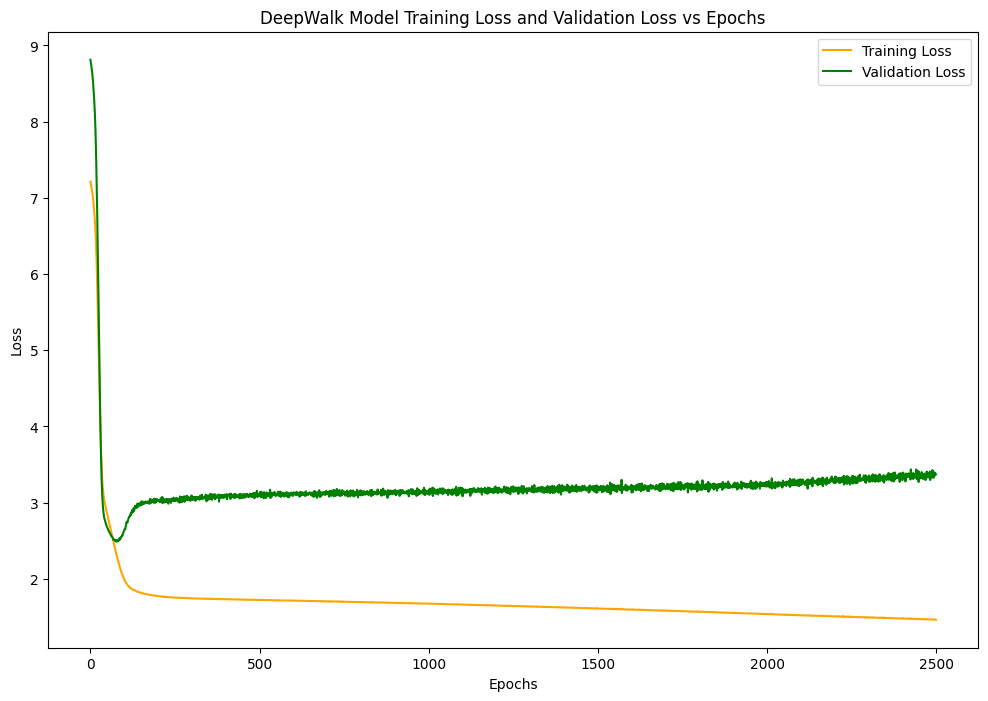

In [17]:
### Plotting the training and validation losses vs epochs for DeepWalk ###
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(dw_history["train"]["loss"], label = "Training Loss", color = "orange")
plt.plot(dw_history["val"]["loss"], label = "Validation Loss", color = "green")
plt.title("DeepWalk Model Training Loss and Validation Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [18]:
##### Getting the test set loss for Deepwalk #####

best_model = GraphRegressionModel(input_dim = input_dim)
best_model.load_state_dict(dw_history["train"]["best_model_checkpoint"])

print("Printing Test Set Preformance for regression model on Deepwalk")

dw_history = evaluate(test_loader, best_model, dw_history, loss_fn)

Printing Test Set Preformance for regression model on Deepwalk
Test MSE Loss = 3.1001704931259155
Test Set RMSE = 1.7607301473617554


# Part A. Node2Vec Training

In [19]:
#### Create dicts for storing tensors ####

from torch.utils.data import TensorDataset, DataLoader
embeds = {
  "train" : None,
  "test" : None,
  "val" : None
}

targets_ = {
  "train" : None,
  "test" : None,
  "val" : None
}

##### Make tensors from the saved embeddings #####
for split in ["train", "val", "test"]:
  embeds[split] = torch.stack(graph_embeds["Node2Vec"][split], dim = 0)
  targets_[split] = torch.FloatTensor(targets[split])

  print(f"Shape of {split} embeddings: {embeds[split].shape}")
  print(f"Shape of {split} targets: {targets_[split].shape}")

###### Creating the dataloader for train, test and val ######
def create_dataloaders(graph_embeds, targets, batch_size, split = "train"):
  dataset = TensorDataset(graph_embeds[split], torch.tensor(targets[split]))
  return DataLoader(dataset, batch_size=50, shuffle= True if split == "train" else False)

train_loader = create_dataloaders(embeds, targets_, batch_size = 50, split = "train")
val_loader = create_dataloaders(embeds, targets_, batch_size = 50, split = "val")
test_loader = create_dataloaders(embeds, targets_, batch_size = 50, split = "test")


Shape of train embeddings: torch.Size([1000, 64])
Shape of train targets: torch.Size([1000])
Shape of val embeddings: torch.Size([100, 64])
Shape of val targets: torch.Size([100])
Shape of test embeddings: torch.Size([100, 64])
Shape of test targets: torch.Size([100])


/tmp/ipykernel_46375/3397401884.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(graph_embeds[split], torch.tensor(targets[split]))


In [20]:
###### Model Definition and hyper parameters for Node2Vec training ######
###### We keep the parameters similar to DeepWalk for better comparison #####

input_dim = 64
model = GraphRegressionModel(input_dim = input_dim)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00003)
epochs = 2500
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device = device)

nv_history = train(model, train_loader, val_loader, epochs, loss_fn, optimizer, device = device)

Epoch 0 / 2500 ---- Training Loss = 7.9925140857696535 ---- Validation Loss = 9.662267208099365
Epoch 1 / 2500 ---- Training Loss = 7.946198201179504 ---- Validation Loss = 9.609374523162842
Saving Model Checkpoint as best Model
Epoch 2 / 2500 ---- Training Loss = 7.9042703866958615 ---- Validation Loss = 9.56399393081665
Saving Model Checkpoint as best Model
Epoch 3 / 2500 ---- Training Loss = 7.8668599128723145 ---- Validation Loss = 9.5208420753479
Saving Model Checkpoint as best Model
Epoch 4 / 2500 ---- Training Loss = 7.830709624290466 ---- Validation Loss = 9.478806972503662
Saving Model Checkpoint as best Model
Epoch 5 / 2500 ---- Training Loss = 7.795539379119873 ---- Validation Loss = 9.434996128082275
Saving Model Checkpoint as best Model
Epoch 6 / 2500 ---- Training Loss = 7.759051012992859 ---- Validation Loss = 9.388421058654785
Saving Model Checkpoint as best Model
Epoch 7 / 2500 ---- Training Loss = 7.720581412315369 ---- Validation Loss = 9.33761215209961
Saving Model 

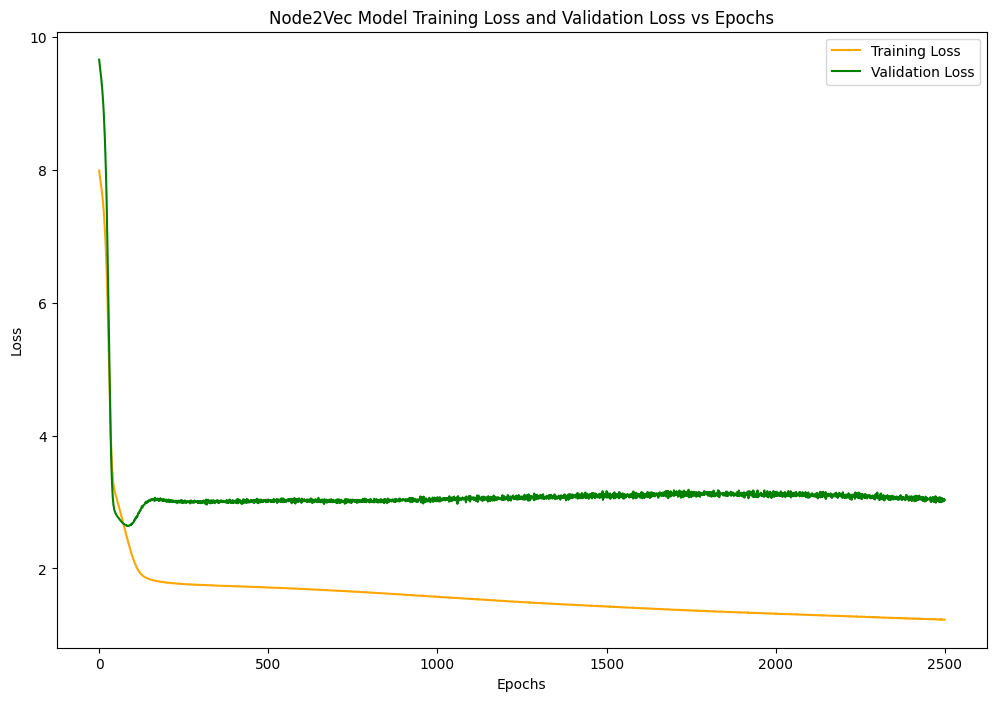

In [21]:
### Plotting the training and validation losses vs epochs for Node2Vec ###
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(nv_history["train"]["loss"], label = "Training Loss", color = "orange")
plt.plot(nv_history["val"]["loss"], label = "Validation Loss", color = "green")
plt.title("Node2Vec Model Training Loss and Validation Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
##### Getting the test set loss for Node2Vec #####

best_model = GraphRegressionModel(input_dim = input_dim)
best_model.load_state_dict(nv_history["train"]["best_model_checkpoint"])

print("Printing Test Set Preformance for regression model on Node2Vec")

nv_history = evaluate(test_loader, best_model, nv_history, loss_fn)

Printing Test Set Preformance for regression model on Node2Vec
Test MSE Loss = 3.4424818754196167
Test Set RMSE = 1.8553926944732666


# **Imp: For the part 2 and 3 you are not allowed to use any library implementation of the models.**

## You are free to change the structure of the code as per you understanding.

## You can write the training loop at once or for individual model, we don't mind untill you produce the required output.

#Part-2:

Here you to provide the custom implementation of Part-2, and then use that custom cretad layer to code the model.



#Part 2 - GCN Implementation

In [23]:
# Code Here
from torch_geometric.nn.pool import global_mean_pool

# Part 2: Graph Convolutional Neural Network (GCN)

class GCNLayer(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNLayer, self).__init__(aggr='add')
        self.linear = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # Add self-loops to the adjacency matrix
        # code here
        edge_index, _ = add_self_loops(edge_index, num_nodes = x.shape[0])
        z = self.linear(x)
        row, col = edge_index
        # Compute normalization
        # code here
        deg = degree(edge_index[1], num_nodes=z.shape[0])
        deg = 1/torch.sqrt(deg)
        deg[deg == float('inf')] = 0
        norm = deg[row] * deg[col]

        # Perform the convolution
        #code here
        out = self.propagate(edge_index = edge_index, x = z, norm = norm)

        return out

    def message(self, x_j, norm):

        return torch.mul(norm.view(-1, 1), x_j)

class GCN(nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()

        # code layers
        self.layer1 = GCNLayer(num_node_features, 128)
        self.layer2 = GCNLayer(128, 64)
        self.layer3 = GCNLayer(64, 32)
        self.layer4 = GCNLayer(32, num_classes)

        self.relu = nn.ReLU()

    def forward(self, data):
        x = self.layer1(data.x, data.edge_index)
        x = self.relu(x)
        x = self.layer2(x, data.edge_index)
        x = self.relu(x)
        x = self.layer3(x, data.edge_index)
        x = self.relu(x)
        x = self.layer4(x, data.edge_index)
        x = self.relu(x)

        x = global_mean_pool(x, data.batch)
        return x

In [24]:
from sklearn.metrics import root_mean_squared_error

#### Here we define the training loop ###
def train(model, train_loader, val_loader, epochs, loss_fn, optimizer, device = "cpu"):
  #### Save training history for saving best model and losses ####
  training_history = {
        "train" : {
            "loss" : [],
            "best_model_checkpoint" : None
          },
        "val" : {
            "loss" : []
          },
        "test" : {
            "loss" : []
          }
    }

  #### Iterate over epochs ###
  for epoch in range(epochs):
    ### Set model for training ###
    model.train()

    train_loss = []
    val_loss = []

    ### Iterate over pygeometric batches ###
    for batch in train_loader:
      optimizer.zero_grad()
      batch = batch.to(device = device)

      ### Get model predictions ###
      targets = batch.y[:,0]
      predictions = model(batch)
      predictions = predictions.squeeze(dim = 1)
      ### Calculate loss ###
      loss = loss_fn(predictions, targets)
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    ### Set eval mode for validation loss calculation ###
    model.eval()
    for batch in val_loader:
      batch = batch.to(device = device)
      targets = batch.y[:,0]
      predictions = model(batch)
      predictions = predictions.squeeze(dim = 1)
      loss = loss_fn(predictions, targets)

      val_loss.append(loss.item())

    ### Save the model if got better validation accuracy till now ###
    if len(training_history["val"]["loss"]) > 1 and np.mean(val_loss) < min(training_history["val"]["loss"]):
      print("Saving Model Checkpoint as best Model")
      training_history["train"]["best_model_checkpoint"] = model.state_dict()

    training_history["train"]["loss"].append(np.mean(train_loss))
    training_history["val"]["loss"].append(np.mean(val_loss))

    print(f"Epoch {epoch} / {epochs} ---- Training Loss = {training_history['train']['loss'][-1]} ---- Validation Loss = {training_history['val']['loss'][-1]}")


  return training_history


def evaluate(test_loader, model, history, loss_fn, device = "cpu"):
  ### Set up model in eval mode ###
  model.eval()

  test_loss = []
  preds = []
  true_labels = []

  ### Iterate over the batch of test pyG dataloader ###
  for batch in test_loader:
    batch = batch.to(device = device)
    targets = batch.y[:,0]

    predictions = model(batch)
    predictions = predictions.squeeze(dim = 1)
    loss = loss_fn(predictions, targets)

    test_loss.append(loss.item())
    preds.extend(list(predictions.detach().numpy()))
    true_labels.extend(list(targets.numpy()))

  history["test"]["loss"].append(np.mean(test_loss))

  print(f"Test MSE Loss = {history['test']['loss'][-1]}")
  print(f"Test RMSE = {root_mean_squared_error(true_labels, preds)}")
  
  return history, preds, true_labels


In [25]:
#### Define model and hyper params

node_features = 11
out_features = 1
model = GCN(node_features, out_features)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device = device)

#### We wish to train for high epochs with lesser learning rate ###
epochs = 2500

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00003)

#### Perform train loop
training_loop = train(model, trainloader, valloader, epochs, loss_fn, optimizer, device = device)

Epoch 0 / 2500 ---- Training Loss = 7.4050922775268555 ---- Validation Loss = 8.290610313415527
Epoch 1 / 2500 ---- Training Loss = 7.022130289077759 ---- Validation Loss = 7.864705562591553
Saving Model Checkpoint as best Model
Epoch 2 / 2500 ---- Training Loss = 6.60982274055481 ---- Validation Loss = 7.400361776351929
Saving Model Checkpoint as best Model
Epoch 3 / 2500 ---- Training Loss = 6.166135225296021 ---- Validation Loss = 6.8978846073150635
Saving Model Checkpoint as best Model
Epoch 4 / 2500 ---- Training Loss = 5.690123238563538 ---- Validation Loss = 6.366177558898926
Saving Model Checkpoint as best Model
Epoch 5 / 2500 ---- Training Loss = 5.175276374816894 ---- Validation Loss = 5.770304203033447
Saving Model Checkpoint as best Model
Epoch 6 / 2500 ---- Training Loss = 4.6249151611328125 ---- Validation Loss = 5.161343812942505
Saving Model Checkpoint as best Model
Epoch 7 / 2500 ---- Training Loss = 4.07279417514801 ---- Validation Loss = 4.532770872116089
Saving Mode

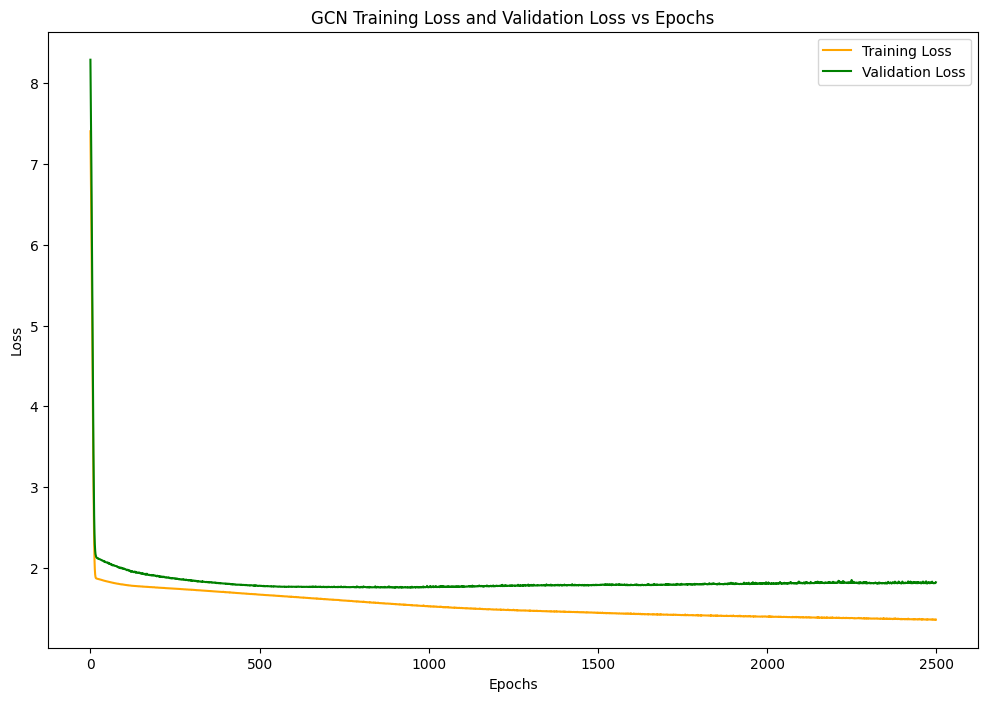

In [26]:
#### PLot train and validation loss history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(training_loop["train"]["loss"], label = "Training Loss", color = "orange")
plt.plot(training_loop["val"]["loss"], label = "Validation Loss", color = "green")
plt.title("GCN Training Loss and Validation Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [27]:
#### Getting the test loss
##### Getting the test set loss #####

best_model = GCN(11,1)
best_model.load_state_dict(training_loop["train"]["best_model_checkpoint"])

print("Printing Test Set Performance for GCN")

_ = evaluate(testloader, best_model, training_loop, loss_fn)

Printing Test Set Performance for GCN
Test MSE Loss = 1.093542218208313
Test RMSE = 1.045725703239441


#Part-3:

Here you to provide the custom implementation of Part-3, and then use that custom cretad layer to code the model.

# Part 3. Graph Attention Network 

In [38]:
# Part 4: Attention-based Graph Neural Network

from torch_geometric.utils import scatter
from torch_geometric.nn.pool import global_mean_pool, global_add_pool

class EGATConv(MessagePassing):
    def __init__(self, in_channels, out_channels, edge_dim, heads=1, layer_type = "intermediate"):
      super(EGATConv, self).__init__(aggr='add', node_dim=0)
      self.in_channels = in_channels
      self.out_channels = out_channels
      self.heads = heads
      self.edge_dim = edge_dim
      self.layer_type = layer_type

      self.lin = nn.Linear(in_channels, heads * out_channels, bias=False)
      self.edgeproj = nn.Linear(edge_dim, heads * out_channels, bias = False)
      # self.att = nn.Linear(3 * out_channels + edge_dim, 1)
      self.att = nn.Linear(3 * out_channels, 1)

      self.reset_parameters()

    def reset_parameters(self):
      nn.init.xavier_uniform_(self.lin.weight)
      nn.init.xavier_uniform_(self.att.weight)
      nn.init.xavier_uniform_(self.edgeproj.weight)

    def forward(self, x, edge_index, edge_attr):
      # code here
      ### Separate the attention heads
      x = self.lin(x)
      x = x.reshape(-1, self.heads, self.out_channels)

      ### Project edge_attr and separate out the attention heads
      edge_attr = self.edgeproj(edge_attr)
      edge_attr = edge_attr.reshape(-1, self.heads, self.out_channels)

      ### Compute attention coefficients
      out = self.propagate(edge_index = edge_index, x = x, edge_attr = edge_attr)

      return out


    def message(self, x_i, x_j, edge_attr, index, ptr, size_i):
      ### Compute the attention coefficients
      z = torch.cat([x_i, x_j, edge_attr], dim = -1)

      alpha = self.att(z)
      alpha = F.leaky_relu(alpha, 0.2)

      ### Normalize the attention weights by softmax
      if ptr:
        alpha = torch_geometric.utils.softmax(alpha, ptr = ptr)
      else:
        alpha = torch_geometric.utils.softmax(alpha, index = index, num_nodes = size_i)

      out = alpha * x_j
      return out

    def aggregate(self, inputs, index, dim_size = None):
      #### We perform sum aggregation of the attended hidden states
      out = scatter(inputs, index, self.node_dim, dim_size, reduce = "sum")

      return out

    def update(self, aggr_out):
        # code here
        #### We donot use the final layer aggregation layer but still keep option for it
        if self.layer_type == "final":
          aggr_out = torch.mean(aggr_out, dim = 1)
        else:
          #### Reshaping the output to N, H*C
          aggr_out = aggr_out.reshape(aggr_out.shape[0], -1)
        return aggr_out
    

class EGATModel(nn.Module):
    def __init__(self, num_node_features, num_edge_features, num_classes):
        super(EGATModel, self).__init__()
        # code here experiment with layers
        self.layer1 = EGATConv(in_channels = num_node_features, out_channels = 64, edge_dim = num_edge_features, heads = 2)
        self.layer2 = EGATConv(in_channels = 128, out_channels = 32, edge_dim = num_edge_features, heads = 2)
        self.layer3 = EGATConv(in_channels = 64, out_channels= 16, edge_dim = num_edge_features, heads = 2)
        self.layer4 = EGATConv(in_channels = 32, out_channels= 16, edge_dim = num_edge_features, heads = 1)
        self.layer5 = EGATConv(in_channels = 16, out_channels= num_classes, edge_dim = num_edge_features, heads = 1)
        
        self.relu = nn.ReLU()

    def forward(self, data):
        # code here
        x = self.layer1(data.x, data.edge_index, data.edge_attr)
        x = self.relu(x)
        x = self.layer2(x, data.edge_index, data.edge_attr)
        x = self.relu(x)
        x = self.layer3(x, data.edge_index, data.edge_attr)
        x = self.relu(x)
        x = self.layer4(x, data.edge_index, data.edge_attr)
        x = self.relu(x)
        x = self.layer5(x, data.edge_index, data.edge_attr)
        x = self.relu(x)

        x = global_mean_pool(x, data.batch)
        return x

# write training loop

In [39]:
# code here
from sklearn.metrics import root_mean_squared_error
#### Here we define the training loop ###

def train(model, train_loader, val_loader, epochs, loss_fn, optimizer, device = "cpu"):
  #### Save training history for saving best model and losses ####
  training_history = {
        "train" : {
            "loss" : [],
            "best_model_checkpoint" : None
          },
        "val" : {
            "loss" : []
          },
        "test" : {
            "loss" : []
          }
    }

  
  ### Iterate Over Epochs ###
  for epoch in range(epochs):
    ### Set up Model in train mode ###
    model.train()

    train_loss = []
    val_loss = []

    for batch in train_loader:
      #### Set up optimizer, get prediction and get loss
      optimizer.zero_grad()

      batch = batch.to(device = device)

      predictions = model(batch)
      predictions = predictions.squeeze(dim = 1)      
      loss = loss_fn(predictions, batch.y[:,0])
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    ### Set up model for validation loop ###
    model.eval()
    for batch in val_loader:
      batch = batch.to(device = device)

      predictions = model(batch)
      predictions = predictions.squeeze(dim = 1)
      loss = loss_fn(predictions, batch.y[:,0])

      val_loss.append(loss.item())

    if len(training_history["val"]["loss"]) > 1 and np.mean(val_loss) < min(training_history["val"]["loss"]):
      print("Saving Model Checkpoint as best Model")
      training_history["train"]["best_model_checkpoint"] = model.state_dict()

    training_history["train"]["loss"].append(np.mean(train_loss))
    training_history["val"]["loss"].append(np.mean(val_loss))

    print(f"Epoch {epoch} / {epochs} ---- Training Loss = {training_history['train']['loss'][-1]} ---- Validation Loss = {training_history['val']['loss'][-1]}")


  return training_history


def evaluate(test_loader, model, history, loss_fn, device = "cpu"):
  ### Set up model in eval loop ###
  model.eval()

  test_loss = []
  preds = []
  true_labels = []

  ### Iterate over test loader ###
  for batch in test_loader:
    batch = batch.to(device = device)

    predictions = model(batch)
    predictions = predictions.squeeze(dim = 1)
    loss = loss_fn(predictions, batch.y[:,0])

    preds.extend(list(predictions.detach().numpy()))
    true_labels.extend(list(batch.y[:,0].numpy()))

    test_loss.append(loss.item())

  history["test"]["loss"].append(np.mean(test_loss))

  print(f"Test MSE Loss = {history['test']['loss'][-1]}")
  print(f"Test RMSE = {root_mean_squared_error(true_labels, preds)}")
  return history, preds, true_labels


In [40]:
#### Define model and hyper params

model = EGATModel(11, 4, 1)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device = device)
epochs = 2500

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00003)

#### Perform train loop
training_loop = train(model, trainloader, valloader, epochs, loss_fn, optimizer, device = device)

Epoch 0 / 2500 ---- Training Loss = 6.557333812713623 ---- Validation Loss = 7.162229776382446
Epoch 1 / 2500 ---- Training Loss = 5.895886998176575 ---- Validation Loss = 6.5336713790893555
Saving Model Checkpoint as best Model
Epoch 2 / 2500 ---- Training Loss = 5.2136709594726565 ---- Validation Loss = 5.601170539855957
Saving Model Checkpoint as best Model
Epoch 3 / 2500 ---- Training Loss = 4.26910626411438 ---- Validation Loss = 4.515528559684753
Saving Model Checkpoint as best Model
Epoch 4 / 2500 ---- Training Loss = 3.41636670589447 ---- Validation Loss = 3.6851712465286255
Saving Model Checkpoint as best Model
Epoch 5 / 2500 ---- Training Loss = 2.8085160183906557 ---- Validation Loss = 3.109847068786621
Saving Model Checkpoint as best Model
Epoch 6 / 2500 ---- Training Loss = 2.417048213481903 ---- Validation Loss = 2.71951961517334
Saving Model Checkpoint as best Model
Epoch 7 / 2500 ---- Training Loss = 2.172102853059769 ---- Validation Loss = 2.4671122431755066
Saving Mod

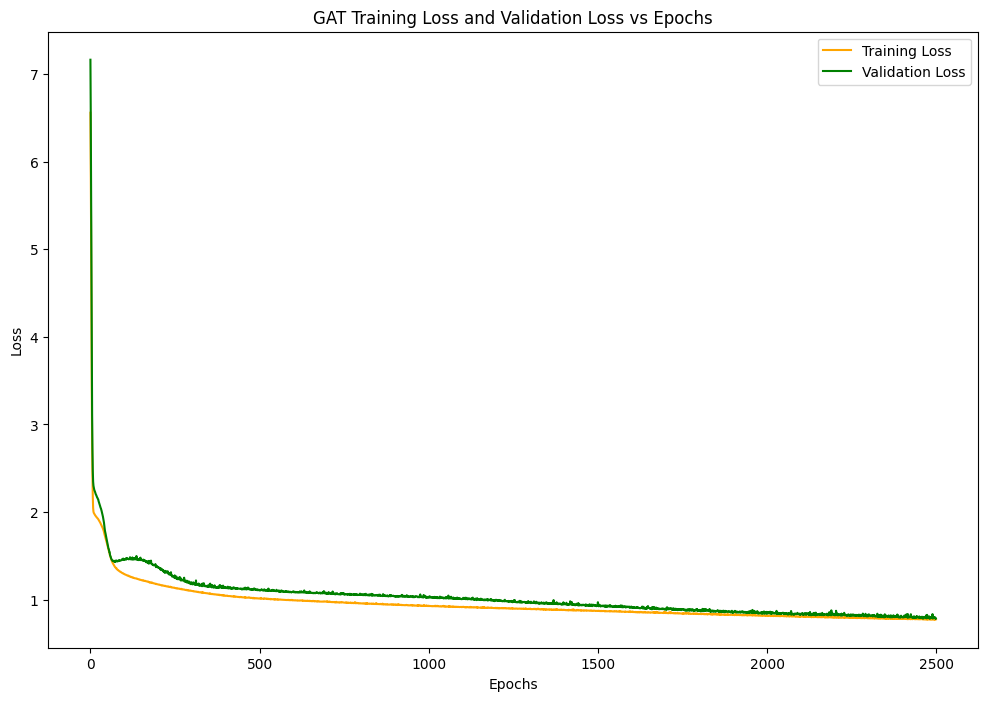

In [41]:
#### PLot train and validation loss history

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.plot(training_loop["train"]["loss"], label = "Training Loss", color = "orange")
plt.plot(training_loop["val"]["loss"], label = "Validation Loss", color = "green")
plt.title("GAT Training Loss and Validation Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [43]:
#### Getting the test loss
##### Getting the test set loss #####

best_model = EGATModel(11, 4, 1)
best_model.load_state_dict(training_loop["train"]["best_model_checkpoint"])

print("Printing Test Set Performance for GAT")

_, preds, true_labels = evaluate(testloader, best_model, training_loop, loss_fn)

Printing Test Set Performance for GAT
Test MSE Loss = 0.6332636773586273
Test RMSE = 0.7957786917686462


## Comparison between models on test Set Performance
```
 Training = 1000 Graphs
 Validation = 100 Graphs
 Test = 100 Graphs
 Batch Size = 50
 Epochs = 2500
 Learning rate kept low to train the model as smoothly as possible. 
 ```

|  | Deepwalk | Node2Vec | GCN | GAT |
|:---:|:-----:|:-----:|:-----:|:------:|
|Test Set RMSE | 1.7607 | 1.855 | 1.045 | 0.7957 |

### Analysis :
We found that as `GAT` works better than all the other models. If more training data is available, the mean batch `RMSE` for test set would be even lower for GAT. We find some overfitting issues in DeepWalk and Node2Vec. But in GCN and GAT we do not find overfitting issue and training is smooth when trained with lower learning rate.

### Training Issues : 
Sometimes the initialization of parameters are such that the loss doesn't decrease at all at first and gets stuck. In these cases we rerun the training again to reinitialize the training loop to start training again.